# Customer Transaction Prediction

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.manifold import TSNE
from time import time
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# Reading training data
data_set_train = pd.read_csv("./train.csv")
trainData_X = data_set_train.drop(['ID_code', 'target'], axis = 1)
trainData_Y = data_set_train['target']
# Reading testing data
data_set_test = pd.read_csv("./test.csv")
testData_X = data_set_test.drop(['ID_code'], axis = 1)

# Data Exploration

In [4]:
data_set_train.isnull().any().any()

False

In [5]:
data_set_test.isnull().any().any()

False

In [6]:
trainData_X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


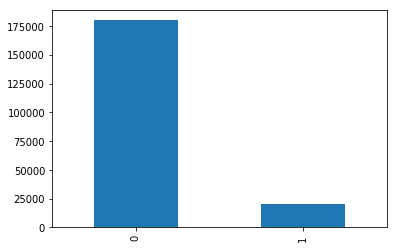

In [8]:
data_set_train['target'].value_counts().plot.bar()

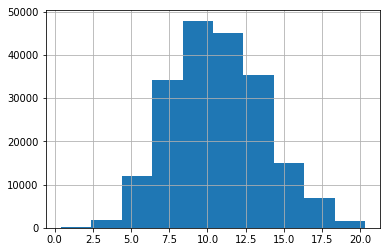

In [9]:
data_set_train["var_0"].hist();

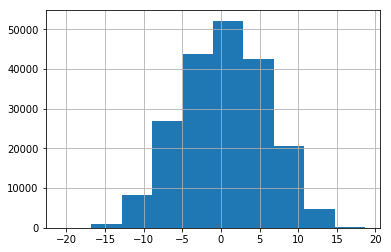

In [10]:
data_set_train["var_10"].hist();

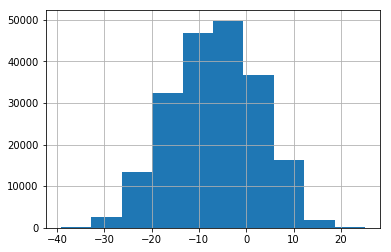

In [11]:
data_set_train["var_100"].hist();

# Data Preprocessing

In [4]:
# Create training and validation set
X_train, X_test, y_train, y_test = train_test_split(trainData_X, trainData_Y, test_size = 0.2)

# Convert the pandas dataframe to numpy array
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# OverSampling
# X_train, y_train = SMOTE().fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Standardize the data
StandardScaler = preprocessing.StandardScaler().fit(X_train)
X_train = StandardScaler.transform(X_train)
X_test = StandardScaler.transform(X_test)

y_train = y_train.reshape(-1, 1)

# One Hot Encoder
oneHot = OneHotEncoder(categories='auto')
oneHot.fit(y_train)
y_train = 1 - oneHot.transform(y_train).toarray()

oneHot.fit(y_test)
y_test = 1 - oneHot.transform(y_test).toarray()

In [5]:
print("X training: ", X_train.shape)
print("y_training: ", y_train.shape)

print("X testing: ", X_test.shape)
print("y_testing: ", y_test.shape)

X training:  (287876, 200)
y_training:  (287876, 2)
X testing:  (40000, 200)
y_testing:  (40000, 2)


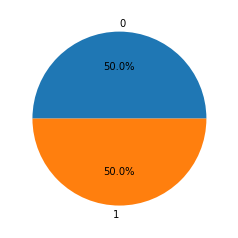

In [33]:
plt.pie([np.sum(y_train == 0), np.sum(y_train == 1)], labels = ["0", "1"], autopct='%1.1f%%')
plt.show()

# Model 1 - SVM

In [5]:
def split_sets(batch, x_all, y_all):
    total_batch = int(len(x_all) / batch)
    rand_x = np.array_split(x_all, total_batch)
    rand_y = np.array_split(y_all, total_batch)
    return rand_x, rand_y, total_batch

def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)

    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig

def show(total_rand_x, total_rand_y, total_batch):
    j = random.randint(0, total_batch - 1)  
    data = total_rand_x[j]
    label = total_rand_y[j]
    n_samples = total_rand_x[j].shape[0]
    n_features = total_rand_x[j].shape[1]
    print('Computing t-SNE embedding')
    tsne = TSNE(n_components=2, init='random', random_state=0)
    t0 = time()
    result = tsne.fit_transform(data)
    fig = plot_embedding(result, label,
                         't-SNE embedding of the digits (time %.2fs)'
                         % (time() - t0))
    plt.show(fig)

In [6]:
# Create training and validation set
x_train_vals, x_test_vals, y_train_vals, y_test_vals = train_test_split(trainData_X, trainData_Y, test_size = 0.2)

# Make the SVM data
test_vals = testData_X.values

x_train_vals = x_train_vals.values
x_test_vals = x_test_vals.values

y_train_vals = y_train_vals.values
y_train_vals = np.array([-1 if y == 0 else 1 for y in y_train_vals]).reshape(-1, 1)

y_test_vals =  y_test_vals.values
y_test_vals = np.array([-1 if y == 0 else 1 for y in y_test_vals]).reshape(-1, 1)

In [9]:
graph = tf.Graph()
batch_size = 5000
n_features = 200
with graph.as_default():
    with tf.name_scope("variables"):
        global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name="global_step")
    
    # get input
    with tf.name_scope("input"):
        # Initialize placeholders
        x_data = tf.placeholder(shape=[None, n_features], dtype=tf.float32)
        y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
        prediction_grid = tf.placeholder(shape=[None, n_features], dtype=tf.float32)

        # Create variables for svm
        b = tf.Variable(tf.random_normal(shape=[1,batch_size]))
        
    # define gaussion kernel
    with tf.name_scope("gaussion_kernel"):
        gamma = tf.constant(-10.0)
        dist = tf.reduce_sum(tf.square(x_data), 1)
        dist = tf.reshape(dist, [-1,1])
        sq_dists = tf.add(tf.subtract(dist, tf.multiply(2.,tf.matmul(x_data, tf.transpose(x_data)))), tf.transpose(dist))
        my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))
#         gamma = tf.constant(-10.0)
#         sq_vec = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
#         my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_vec)))
        
    # measuring the dual to compute loss
    with tf.name_scope("Dual_measuring"):
        first_term = tf.reduce_sum(b)
        b_vec_cross = tf.matmul(tf.transpose(b), b)
        y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
        second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
        loss = tf.negative(tf.subtract(first_term, second_term))
    
    # make prediction
    with tf.name_scope("predict_and_accuracy"):
        rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1), [-1,1])
        rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1,1])
        pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
        pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

        prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target), b), pred_kernel)
        prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction),tf.squeeze(y_target)), tf.float32))
        
    with tf.name_scope("optimizer"):
        my_opt = tf.train.GradientDescentOptimizer(0.001)
        train_step = my_opt.minimize(loss)
        
    with tf.name_scope("summaries"):
        tf.summary.scalar("predication_accuracy", accuracy)
        tf.summary.scalar("loss", loss)
    
    with tf.name_scope("global_ops"):
        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        merged_summary = tf.summary.merge_all()
        increment_step = global_step.assign_add(1)

with tf.Session(graph = graph) as sess:
    Writer = tf.summary.FileWriter("./", graph)
    sess.run(init)

    loss_vec = []
    batch_accuracy = []
    for i in range(100):
        total_rand_x, total_rand_y, total_batch = split_sets(batch_size, x_train_vals, y_train_vals)
        
        for j in range(total_batch):
            rand_x = np.array(total_rand_x[j])
            rand_y = np.array(total_rand_y[j]).reshape(-1, 1)
            sess.run(train_step,feed_dict={x_data:rand_x, y_target:rand_y})
            
            temp_loss = sess.run(loss, feed_dict = {x_data:rand_x, y_target:rand_y})
            loss_vec.append(temp_loss)
            acc_temp, summary, step, predictions = sess.run([accuracy, merged_summary, increment_step, prediction],feed_dict={x_data:rand_x, y_target:rand_y, prediction_grid:rand_x})
            batch_accuracy.append(acc_temp)
            if j % 100 == 0:
                print('Train loss = ' + str(temp_loss), "Train accuracy: ", acc_temp)
                
        Writer.add_summary(summary, global_step=step)

Train loss = 5001.619 Train accuracy:  0.4984
Train loss = 4249.8027 Train accuracy:  0.5038
Train loss = 3588.4 Train accuracy:  0.5088
Train loss = 3006.537 Train accuracy:  0.515
Train loss = 2494.6484 Train accuracy:  0.5192
Train loss = 2044.3192 Train accuracy:  0.526
Train loss = 1648.1465 Train accuracy:  0.5334
Train loss = 1299.6173 Train accuracy:  0.539
Train loss = 993.00183 Train accuracy:  0.5476
Train loss = 723.2595 Train accuracy:  0.556
Train loss = 485.9568 Train accuracy:  0.5626
Train loss = 277.19177 Train accuracy:  0.5702
Train loss = 93.532715 Train accuracy:  0.5774
Train loss = -68.04004 Train accuracy:  0.5846
Train loss = -210.18176 Train accuracy:  0.594
Train loss = -335.22925 Train accuracy:  0.6034
Train loss = -445.23914 Train accuracy:  0.613
Train loss = -542.01953 Train accuracy:  0.6206
Train loss = -627.1603 Train accuracy:  0.628
Train loss = -702.06287 Train accuracy:  0.6362
Train loss = -767.95764 Train accuracy:  0.6436
Train loss = -825.927

KeyboardInterrupt: 

# Model 2 - A Simple Neural Network

In [38]:
# Specify some constant value
n_hidden_1 = 50
n_hidden_2 = 25
n_features = 200

# Build the graph
myGraph = tf.Graph()
with myGraph.as_default():
    # Define the model
    def Net(x, weights, biases):
        
        with tf.name_scope("Layer_1"):
            layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
            layer_1 = tf.layers.batch_normalization(layer_1)
            layer_1 = tf.nn.leaky_relu(layer_1)
        
        with tf.name_scope("Layer_2"):
            layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
            layer_2 = tf.layers.batch_normalization(layer_2)
            layer_2 = tf.nn.leaky_relu(layer_2)
        
        with tf.name_scope("Output_Layer"):
            logits = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
            
        return logits
    
    with tf.name_scope("Weights"):
        # Weight variables
        weights = {
            'h1': tf.Variable(tf.random_normal([n_features, n_hidden_1]), name = "W1"),
            'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]), name = "W2"),
            'out': tf.Variable(tf.random_normal([n_hidden_2, 2]), name = "W3")
        }

        biases = {
            'b1': tf.Variable(tf.random_normal([n_hidden_1]), name = "b1"),
            'b2': tf.Variable(tf.random_normal([n_hidden_2]), name = "b2"),
            'out': tf.Variable(tf.random_normal([2]), name = "b3")
        }
        
        # Gobal step
        global_step = tf.Variable(1, dtype = tf.int32, name = "global_step")
        global_step_op = global_step.assign_add(1)
        
    with tf.name_scope("Input_Layer"):
        # Placeholder for X and Y values
        x = tf.placeholder("float", [None, n_features], name = "X")
        y = tf.placeholder("float", [None, 2], name = "y")
    
    # Initialize the model
    logits = Net(x, weights, biases)
    y_pred = tf.nn.softmax(logits, name = "y_pred")
    
    with tf.name_scope("Loss_and_Accuracy"):
        # Loss
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = y), name = "Loss")
        
        # Training accuracy
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1)), tf.float32))
        
        # Confusion matrix
        confusion_matrix = tf.confusion_matrix(tf.argmax(logits, 1), tf.argmax(y, 1 ))
        
    with tf.name_scope("AUC"):
        auc, auc_update_op = tf.metrics.auc(predictions = y_pred, labels = y, curve = 'ROC')
        auc_variables = [ v for v in tf.local_variables() if v.name.startswith( "AUC" ) ]
        auc_reset_op = tf.initialize_variables(auc_variables)
        
    # Optimizer
    lr = tf.train.exponential_decay(0.001, global_step, 10000, 0.95, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)
    
    with tf.name_scope("Summary"):
        # Summary
        tf.summary.scalar('Loss', loss)
        merged_summaries = tf.summary.merge_all()

In [41]:
def show_progress(epoch, feed_dict_train, feed_dict_test, loss):
    acc, auc_value = sess.run([accuracy, auc_update_op], feed_dict = feed_dict_train)
    sess.run(auc_reset_op)
    test_acc, test_auc_value = sess.run([accuracy, auc_update_op], feed_dict = feed_dict_test)
    sess.run(auc_reset_op)
    msg = 'Training Epoch {} - Train Acc: {:>6.1%}, Train AUC: {:>6.1%}, Test Acc: {:>6.1%}, Test AUC: {:>6.1%}, Loss: {:.6f}'
    print(msg.format(epoch + 1, acc, auc_value, test_acc, test_auc_value, loss))
    
    if (epoch + 1) % 100 == 0:
        print("Train: \n", confusion_matrix.eval(feed_dict_train))
        print("Test: \n", confusion_matrix.eval(feed_dict_test))
def train(num_iteration):
    for i in range(0, num_iteration):
        
        total_batch = int(len(X_train) / 1000)
        feed_dict_train = {x: X_train, y: y_train}
        feed_dict_test = {x: X_test, y: y_test}
        
        for j in range(total_batch):
            x_batches = np.array_split(X_train, total_batch)
            y_batches = np.array_split(y_train, total_batch)

            feed_dict_train_batch = {x: x_batches[j], y: y_batches[j]}

            _, auc, s = sess.run([optimizer, auc_update_op, global_step_op], feed_dict = feed_dict_train_batch)
        
        l, summary = sess.run([loss, merged_summaries], feed_dict = feed_dict_train)   
        show_progress(i, feed_dict_train, feed_dict_test, l)
        writer.add_summary(summary)

In [42]:
with tf.Session(graph = myGraph) as sess:
    writer = tf.summary.FileWriter('./', myGraph)
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run( init ) 
    train(num_iteration = 1000)
    writer.flush()
    writer.close()

Training Epoch 1 - Train Acc:  52.4%, Train AUC:  66.5%, Test Acc:  16.0%, Test AUC:  15.7%, Loss: 57.777241
Training Epoch 2 - Train Acc:  56.9%, Train AUC:  66.4%, Test Acc:  24.8%, Test AUC:  24.2%, Loss: 28.162249
Training Epoch 3 - Train Acc:  59.4%, Train AUC:  69.1%, Test Acc:  29.8%, Test AUC:  29.0%, Loss: 18.827013
Training Epoch 4 - Train Acc:  61.1%, Train AUC:  70.5%, Test Acc:  32.8%, Test AUC:  31.8%, Loss: 13.761130
Training Epoch 5 - Train Acc:  62.2%, Train AUC:  71.4%, Test Acc:  34.8%, Test AUC:  33.8%, Loss: 10.395540
Training Epoch 6 - Train Acc:  62.9%, Train AUC:  72.1%, Test Acc:  36.3%, Test AUC:  35.3%, Loss: 8.005305
Training Epoch 7 - Train Acc:  63.5%, Train AUC:  72.7%, Test Acc:  37.6%, Test AUC:  36.4%, Loss: 6.228761
Training Epoch 8 - Train Acc:  63.9%, Train AUC:  73.3%, Test Acc:  38.6%, Test AUC:  37.1%, Loss: 4.903186
Training Epoch 9 - Train Acc:  64.2%, Train AUC:  73.9%, Test Acc:  39.3%, Test AUC:  37.5%, Loss: 3.907917
Training Epoch 10 - Tra

Training Epoch 77 - Train Acc:  71.5%, Train AUC:  83.9%, Test Acc:  50.5%, Test AUC:  50.7%, Loss: 0.711989
Training Epoch 78 - Train Acc:  72.0%, Train AUC:  84.3%, Test Acc:  51.6%, Test AUC:  52.3%, Loss: 0.688829
Training Epoch 79 - Train Acc:  72.7%, Train AUC:  84.6%, Test Acc:  52.7%, Test AUC:  53.7%, Loss: 0.670899
Training Epoch 80 - Train Acc:  72.2%, Train AUC:  84.4%, Test Acc:  51.6%, Test AUC:  52.2%, Loss: 0.682260
Training Epoch 81 - Train Acc:  73.0%, Train AUC:  84.9%, Test Acc:  53.0%, Test AUC:  54.3%, Loss: 0.654583
Training Epoch 82 - Train Acc:  72.4%, Train AUC:  84.7%, Test Acc:  51.7%, Test AUC:  52.5%, Loss: 0.665397
Training Epoch 83 - Train Acc:  72.7%, Train AUC:  84.9%, Test Acc:  52.2%, Test AUC:  53.2%, Loss: 0.653613
Training Epoch 84 - Train Acc:  71.2%, Train AUC:  84.3%, Test Acc:  49.3%, Test AUC:  49.5%, Loss: 0.681333
Training Epoch 85 - Train Acc:  72.6%, Train AUC:  85.0%, Test Acc:  52.0%, Test AUC:  53.0%, Loss: 0.652142
Training Epoch 86 -

Training Epoch 151 - Train Acc:  75.4%, Train AUC:  88.4%, Test Acc:  54.7%, Test AUC:  56.8%, Loss: 0.605713
Training Epoch 152 - Train Acc:  75.5%, Train AUC:  88.5%, Test Acc:  54.9%, Test AUC:  57.0%, Loss: 0.603398
Training Epoch 153 - Train Acc:  75.5%, Train AUC:  88.4%, Test Acc:  54.8%, Test AUC:  56.9%, Loss: 0.605776
Training Epoch 154 - Train Acc:  75.5%, Train AUC:  88.5%, Test Acc:  54.9%, Test AUC:  57.0%, Loss: 0.604767
Training Epoch 155 - Train Acc:  75.7%, Train AUC:  88.6%, Test Acc:  55.3%, Test AUC:  57.5%, Loss: 0.599327
Training Epoch 156 - Train Acc:  75.8%, Train AUC:  88.6%, Test Acc:  55.5%, Test AUC:  57.7%, Loss: 0.596992
Training Epoch 157 - Train Acc:  75.9%, Train AUC:  88.7%, Test Acc:  55.6%, Test AUC:  57.8%, Loss: 0.595900
Training Epoch 158 - Train Acc:  75.9%, Train AUC:  88.7%, Test Acc:  55.7%, Test AUC:  58.0%, Loss: 0.594921
Training Epoch 159 - Train Acc:  76.0%, Train AUC:  88.8%, Test Acc:  55.8%, Test AUC:  58.1%, Loss: 0.594027
Training E

Training Epoch 225 - Train Acc:  78.4%, Train AUC:  90.4%, Test Acc:  59.0%, Test AUC:  62.2%, Loss: 0.560548
Training Epoch 226 - Train Acc:  76.6%, Train AUC:  89.5%, Test Acc:  56.0%, Test AUC:  58.1%, Loss: 0.632069
Training Epoch 227 - Train Acc:  78.3%, Train AUC:  90.3%, Test Acc:  58.9%, Test AUC:  62.1%, Loss: 0.564791
Training Epoch 228 - Train Acc:  78.6%, Train AUC:  90.5%, Test Acc:  59.2%, Test AUC:  62.6%, Loss: 0.557208
Training Epoch 229 - Train Acc:  78.7%, Train AUC:  90.5%, Test Acc:  59.4%, Test AUC:  62.8%, Loss: 0.553699
Training Epoch 230 - Train Acc:  78.8%, Train AUC:  90.6%, Test Acc:  59.5%, Test AUC:  63.0%, Loss: 0.551744
Training Epoch 231 - Train Acc:  78.8%, Train AUC:  90.6%, Test Acc:  59.6%, Test AUC:  63.1%, Loss: 0.550114
Training Epoch 232 - Train Acc:  78.6%, Train AUC:  90.5%, Test Acc:  59.3%, Test AUC:  62.7%, Loss: 0.557697
Training Epoch 233 - Train Acc:  78.6%, Train AUC:  90.5%, Test Acc:  59.2%, Test AUC:  62.6%, Loss: 0.557457
Training E

Training Epoch 300 - Train Acc:  80.6%, Train AUC:  91.5%, Test Acc:  62.1%, Test AUC:  66.3%, Loss: 0.512735
Train: 
 [[143023  55075]
 [   902  88850]]
Test: 
 [[ 3274 14404]
 [  749 21573]]
Training Epoch 301 - Train Acc:  80.5%, Train AUC:  91.5%, Test Acc:  62.1%, Test AUC:  66.2%, Loss: 0.513874
Training Epoch 302 - Train Acc:  80.0%, Train AUC:  91.3%, Test Acc:  61.2%, Test AUC:  65.0%, Loss: 0.527313
Training Epoch 303 - Train Acc:  80.8%, Train AUC:  91.6%, Test Acc:  62.4%, Test AUC:  66.7%, Loss: 0.508363
Training Epoch 304 - Train Acc:  80.8%, Train AUC:  91.6%, Test Acc:  62.5%, Test AUC:  66.8%, Loss: 0.507848
Training Epoch 305 - Train Acc:  80.8%, Train AUC:  91.6%, Test Acc:  62.5%, Test AUC:  66.8%, Loss: 0.507158
Training Epoch 306 - Train Acc:  80.8%, Train AUC:  91.6%, Test Acc:  62.6%, Test AUC:  66.9%, Loss: 0.506367
Training Epoch 307 - Train Acc:  80.6%, Train AUC:  91.5%, Test Acc:  62.1%, Test AUC:  66.3%, Loss: 0.514077
Training Epoch 308 - Train Acc:  80.8

Training Epoch 374 - Train Acc:  82.4%, Train AUC:  92.4%, Test Acc:  65.0%, Test AUC:  69.9%, Loss: 0.471091
Training Epoch 375 - Train Acc:  82.4%, Train AUC:  92.4%, Test Acc:  65.0%, Test AUC:  69.9%, Loss: 0.470779
Training Epoch 376 - Train Acc:  82.4%, Train AUC:  92.4%, Test Acc:  65.1%, Test AUC:  70.0%, Loss: 0.469789
Training Epoch 377 - Train Acc:  82.5%, Train AUC:  92.4%, Test Acc:  65.1%, Test AUC:  70.0%, Loss: 0.469645
Training Epoch 378 - Train Acc:  82.5%, Train AUC:  92.4%, Test Acc:  65.2%, Test AUC:  70.1%, Loss: 0.468551
Training Epoch 379 - Train Acc:  78.7%, Train AUC:  90.7%, Test Acc:  58.9%, Test AUC:  62.0%, Loss: 0.583382
Training Epoch 380 - Train Acc:  81.9%, Train AUC:  92.1%, Test Acc:  64.3%, Test AUC:  68.9%, Loss: 0.483029
Training Epoch 381 - Train Acc:  82.2%, Train AUC:  92.3%, Test Acc:  64.7%, Test AUC:  69.4%, Loss: 0.477036
Training Epoch 382 - Train Acc:  82.3%, Train AUC:  92.3%, Test Acc:  64.8%, Test AUC:  69.6%, Loss: 0.474509
Training E

Training Epoch 448 - Train Acc:  82.2%, Train AUC:  92.3%, Test Acc:  64.6%, Test AUC:  69.1%, Loss: 0.481414
Training Epoch 449 - Train Acc:  83.2%, Train AUC:  92.8%, Test Acc:  66.1%, Test AUC:  71.4%, Loss: 0.450959
Training Epoch 450 - Train Acc:  83.4%, Train AUC:  92.8%, Test Acc:  66.4%, Test AUC:  71.7%, Loss: 0.446945
Training Epoch 451 - Train Acc:  83.4%, Train AUC:  92.9%, Test Acc:  66.5%, Test AUC:  71.8%, Loss: 0.445850
Training Epoch 452 - Train Acc:  83.5%, Train AUC:  92.9%, Test Acc:  66.6%, Test AUC:  72.0%, Loss: 0.443840
Training Epoch 453 - Train Acc:  83.2%, Train AUC:  92.8%, Test Acc:  66.1%, Test AUC:  71.3%, Loss: 0.451533
Training Epoch 454 - Train Acc:  84.0%, Train AUC:  93.0%, Test Acc:  67.3%, Test AUC:  72.9%, Loss: 0.430352
Training Epoch 455 - Train Acc:  84.0%, Train AUC:  93.1%, Test Acc:  67.4%, Test AUC:  73.0%, Loss: 0.429201
Training Epoch 456 - Train Acc:  84.1%, Train AUC:  93.1%, Test Acc:  67.5%, Test AUC:  73.1%, Loss: 0.427474
Training E

Training Epoch 522 - Train Acc:  85.0%, Train AUC:  93.5%, Test Acc:  69.0%, Test AUC:  74.9%, Loss: 0.404316
Training Epoch 523 - Train Acc:  85.3%, Train AUC:  93.6%, Test Acc:  69.5%, Test AUC:  75.5%, Loss: 0.396029
Training Epoch 524 - Train Acc:  85.3%, Train AUC:  93.6%, Test Acc:  69.6%, Test AUC:  75.6%, Loss: 0.394591
Training Epoch 525 - Train Acc:  85.4%, Train AUC:  93.6%, Test Acc:  69.6%, Test AUC:  75.6%, Loss: 0.393770
Training Epoch 526 - Train Acc:  84.9%, Train AUC:  93.5%, Test Acc:  68.8%, Test AUC:  74.7%, Loss: 0.406199
Training Epoch 527 - Train Acc:  85.3%, Train AUC:  93.6%, Test Acc:  69.5%, Test AUC:  75.5%, Loss: 0.395618
Training Epoch 528 - Train Acc:  85.4%, Train AUC:  93.6%, Test Acc:  69.6%, Test AUC:  75.6%, Loss: 0.394247
Training Epoch 529 - Train Acc:  85.4%, Train AUC:  93.6%, Test Acc:  69.6%, Test AUC:  75.6%, Loss: 0.393961
Training Epoch 530 - Train Acc:  85.2%, Train AUC:  93.6%, Test Acc:  69.4%, Test AUC:  75.3%, Loss: 0.398036
Training E

Training Epoch 597 - Train Acc:  86.0%, Train AUC:  93.9%, Test Acc:  70.6%, Test AUC:  76.7%, Loss: 0.377025
Training Epoch 598 - Train Acc:  86.2%, Train AUC:  94.0%, Test Acc:  70.9%, Test AUC:  77.1%, Loss: 0.372835
Training Epoch 599 - Train Acc:  86.2%, Train AUC:  94.0%, Test Acc:  71.0%, Test AUC:  77.2%, Loss: 0.371616
Training Epoch 600 - Train Acc:  86.3%, Train AUC:  94.0%, Test Acc:  71.0%, Test AUC:  77.2%, Loss: 0.371267
Train: 
 [[142557  38157]
 [  1368 105768]]
Test: 
 [[ 2910 10480]
 [ 1113 25497]]
Training Epoch 601 - Train Acc:  86.3%, Train AUC:  94.0%, Test Acc:  71.1%, Test AUC:  77.3%, Loss: 0.370739
Training Epoch 602 - Train Acc:  86.3%, Train AUC:  94.0%, Test Acc:  71.1%, Test AUC:  77.3%, Loss: 0.370418
Training Epoch 603 - Train Acc:  86.3%, Train AUC:  94.0%, Test Acc:  71.1%, Test AUC:  77.3%, Loss: 0.370138
Training Epoch 604 - Train Acc:  86.3%, Train AUC:  94.0%, Test Acc:  71.1%, Test AUC:  77.3%, Loss: 0.370255
Training Epoch 605 - Train Acc:  86.3

Training Epoch 671 - Train Acc:  87.0%, Train AUC:  94.3%, Test Acc:  72.2%, Test AUC:  78.5%, Loss: 0.353096
Training Epoch 672 - Train Acc:  87.0%, Train AUC:  94.3%, Test Acc:  72.3%, Test AUC:  78.6%, Loss: 0.352277
Training Epoch 673 - Train Acc:  87.0%, Train AUC:  94.3%, Test Acc:  72.3%, Test AUC:  78.6%, Loss: 0.351704
Training Epoch 674 - Train Acc:  87.1%, Train AUC:  94.3%, Test Acc:  72.3%, Test AUC:  78.6%, Loss: 0.351290
Training Epoch 675 - Train Acc:  87.1%, Train AUC:  94.3%, Test Acc:  72.4%, Test AUC:  78.7%, Loss: 0.351018
Training Epoch 676 - Train Acc:  87.1%, Train AUC:  94.3%, Test Acc:  72.4%, Test AUC:  78.7%, Loss: 0.350468
Training Epoch 677 - Train Acc:  87.1%, Train AUC:  94.3%, Test Acc:  72.4%, Test AUC:  78.7%, Loss: 0.350769
Training Epoch 678 - Train Acc:  87.1%, Train AUC:  94.4%, Test Acc:  72.5%, Test AUC:  78.7%, Loss: 0.349977
Training Epoch 679 - Train Acc:  87.1%, Train AUC:  94.3%, Test Acc:  72.5%, Test AUC:  78.7%, Loss: 0.350091
Training E

Training Epoch 745 - Train Acc:  87.7%, Train AUC:  94.6%, Test Acc:  73.5%, Test AUC:  79.9%, Loss: 0.334091
Training Epoch 746 - Train Acc:  87.8%, Train AUC:  94.6%, Test Acc:  73.5%, Test AUC:  79.9%, Loss: 0.333556
Training Epoch 747 - Train Acc:  87.8%, Train AUC:  94.6%, Test Acc:  73.6%, Test AUC:  79.9%, Loss: 0.333106
Training Epoch 748 - Train Acc:  87.8%, Train AUC:  94.6%, Test Acc:  73.6%, Test AUC:  80.0%, Loss: 0.332843
Training Epoch 749 - Train Acc:  87.8%, Train AUC:  94.6%, Test Acc:  73.6%, Test AUC:  80.0%, Loss: 0.332607
Training Epoch 750 - Train Acc:  87.8%, Train AUC:  94.6%, Test Acc:  73.6%, Test AUC:  80.0%, Loss: 0.332446
Training Epoch 751 - Train Acc:  87.8%, Train AUC:  94.6%, Test Acc:  73.6%, Test AUC:  80.0%, Loss: 0.332255
Training Epoch 752 - Train Acc:  87.8%, Train AUC:  94.6%, Test Acc:  73.6%, Test AUC:  80.0%, Loss: 0.332157
Training Epoch 753 - Train Acc:  87.8%, Train AUC:  94.6%, Test Acc:  73.6%, Test AUC:  80.0%, Loss: 0.332013
Training E

Training Epoch 819 - Train Acc:  88.3%, Train AUC:  94.8%, Test Acc:  74.3%, Test AUC:  80.7%, Loss: 0.320761
Training Epoch 820 - Train Acc:  88.4%, Train AUC:  94.9%, Test Acc:  74.5%, Test AUC:  81.0%, Loss: 0.317944
Training Epoch 821 - Train Acc:  88.4%, Train AUC:  94.9%, Test Acc:  74.5%, Test AUC:  81.0%, Loss: 0.317519
Training Epoch 822 - Train Acc:  88.4%, Train AUC:  94.9%, Test Acc:  74.5%, Test AUC:  81.0%, Loss: 0.317976
Training Epoch 823 - Train Acc:  88.3%, Train AUC:  94.8%, Test Acc:  74.4%, Test AUC:  80.8%, Loss: 0.319690
Training Epoch 824 - Train Acc:  88.4%, Train AUC:  94.9%, Test Acc:  74.5%, Test AUC:  81.0%, Loss: 0.317951
Training Epoch 825 - Train Acc:  88.4%, Train AUC:  94.9%, Test Acc:  74.4%, Test AUC:  80.9%, Loss: 0.318800
Training Epoch 826 - Train Acc:  88.4%, Train AUC:  94.9%, Test Acc:  74.5%, Test AUC:  81.0%, Loss: 0.317411
Training Epoch 827 - Train Acc:  88.5%, Train AUC:  94.9%, Test Acc:  74.6%, Test AUC:  81.1%, Loss: 0.316961
Training E

Training Epoch 894 - Train Acc:  89.0%, Train AUC:  95.1%, Test Acc:  75.4%, Test AUC:  81.9%, Loss: 0.304578
Training Epoch 895 - Train Acc:  89.0%, Train AUC:  95.1%, Test Acc:  75.4%, Test AUC:  81.9%, Loss: 0.304478
Training Epoch 896 - Train Acc:  89.0%, Train AUC:  95.1%, Test Acc:  75.4%, Test AUC:  81.9%, Loss: 0.304458
Training Epoch 897 - Train Acc:  89.0%, Train AUC:  95.1%, Test Acc:  75.4%, Test AUC:  81.9%, Loss: 0.304727
Training Epoch 898 - Train Acc:  89.0%, Train AUC:  95.1%, Test Acc:  75.4%, Test AUC:  81.9%, Loss: 0.304277
Training Epoch 899 - Train Acc:  88.9%, Train AUC:  95.1%, Test Acc:  75.3%, Test AUC:  81.9%, Loss: 0.305497
Training Epoch 900 - Train Acc:  89.0%, Train AUC:  95.1%, Test Acc:  75.4%, Test AUC:  81.9%, Loss: 0.304495
Train: 
 [[141978  29801]
 [  1947 114124]]
Test: 
 [[ 2720  8543]
 [ 1303 27434]]
Training Epoch 901 - Train Acc:  89.0%, Train AUC:  95.1%, Test Acc:  75.4%, Test AUC:  82.0%, Loss: 0.304298
Training Epoch 902 - Train Acc:  89.0

Training Epoch 968 - Train Acc:  89.5%, Train AUC:  95.3%, Test Acc:  76.2%, Test AUC:  82.8%, Loss: 0.292796
Training Epoch 969 - Train Acc:  89.4%, Train AUC:  95.2%, Test Acc:  76.2%, Test AUC:  82.7%, Loss: 0.293287
Training Epoch 970 - Train Acc:  89.5%, Train AUC:  95.3%, Test Acc:  76.3%, Test AUC:  82.8%, Loss: 0.292720
Training Epoch 971 - Train Acc:  89.4%, Train AUC:  95.2%, Test Acc:  76.1%, Test AUC:  82.6%, Loss: 0.294519
Training Epoch 972 - Train Acc:  89.4%, Train AUC:  95.2%, Test Acc:  76.2%, Test AUC:  82.7%, Loss: 0.293606
Training Epoch 973 - Train Acc:  89.4%, Train AUC:  95.3%, Test Acc:  76.2%, Test AUC:  82.7%, Loss: 0.292891
Training Epoch 974 - Train Acc:  89.5%, Train AUC:  95.3%, Test Acc:  76.3%, Test AUC:  82.8%, Loss: 0.292866
Training Epoch 975 - Train Acc:  89.5%, Train AUC:  95.3%, Test Acc:  76.3%, Test AUC:  82.8%, Loss: 0.292747
Training Epoch 976 - Train Acc:  89.6%, Train AUC:  95.3%, Test Acc:  76.5%, Test AUC:  83.1%, Loss: 0.288644
Training E